### C12880MA breakout test
Simple notebook to read spectral data from the C12880MA breakout via a ESP32 microcontroller ([HUZZAH32](https://www.adafruit.com/product/3405)) running [MicroPython](https://micropython.org/).
The notebook uses [`pyboard.py`](https://docs.micropython.org/en/latest/reference/pyboard.py.html), a library that allows running MicroPython code via USB and [REPL](https://docs.micropython.org/en/latest/wipy/tutorial/repl.html) on the microcontroller

In [1]:
import pyboard
import time
import json
import numpy as np
from pylab import *

pb = None

Generate a pyboard object on the COM port connected to the ESP32 (here `COM13`)

In [2]:
if pb is None:
    try:
        pb = pyboard.Pyboard("COM13")
    except pyboard.PyboardError as e:
        print(e)     

Enter REPL mode; the MicroPython "shell" is now ready to receive commands

In [3]:
pb.enter_raw_repl()   

Define a function that runs the code contained in a list of strings on the ESP32. By default, it does not print any text coming from the microcontroller into the history. The function returns the output of the last command as a string.

In [4]:
def run_on_board(code, wait_s=0, no_print=False):
    for ln in code:
        res = pb.exec(ln)
        if len(res) > 0 and not no_print:
            res = res[:-2].decode()
            print(res)
    if wait_s > 0:
        time.sleep(wait_s)        
    return res    

The following script is run on the ESP32: it import the C12880MA chip driver and generates a C12880MA by passing the pins to which it is connected. Then it initializes the driver and sets the integration time (in [s]). The script returns a list of wavelengths (in [nm]) at which the spectrometer chip performs the measurements.
As `run_on_board` returns a string, the `json` library is used to convert it to a Python list.

In [5]:
script = [
    'from c12880ma import C12880MA',
    'sp = C12880MA(trg=14, st=15, clk=21, video=36)',
    'sp.begin()',
    'sp.setIntegrationTime_s(0.01)',
    'print(list(sp.wavelengths))'
]
nm = json.loads(run_on_board(script, wait_s=0.4, no_print=True))

Here is a picture of the test circuit:

<p align="center">
  <img width="720" src="https://github.com/eulerlab/spectral_scanner/blob/main/pics/Wiring_c12880_test.png"></img>
</p>

Define a function that reads a spectrum from the C12880MA chip and returns it as a list.

In [6]:
def get_spectrum():
    script = [
        'sp.read()',
        'print(list(sp.spectrum))'
    ]
    raw = json.loads(run_on_board(script, no_print=True))
    return raw

Finally, test the functionality: Read a new spectrum (`data`) and plot it as a function of wavelength (`nm`).

(0.0, 3000.0)

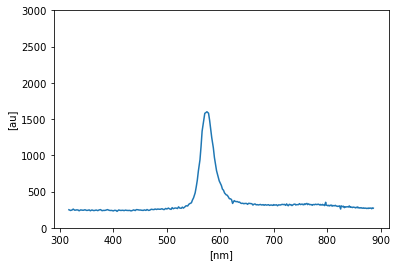

In [10]:
data = get_spectrum()
plot(nm, data)
ylabel("[au]")
xlabel("[nm]")
ylim(0,3000)